In [ ]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=933bf2019598915375b0e04316c0dccb80351685f726ebb548fb3d680e138361
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import os
import logging

import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.autograd import Function
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary
from PIL import Image
import numpy as np
import math
import torch.utils.model_zoo as model_zoo
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix as s_cm
import pandas as pd
import seaborn as sn

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
import import_ipynb
from net import resnet32
from cifar100_Rseed import cifar_100

CUDA_LAUNCH_BLOCKING=1

DEVICE = 'cuda' # 'cuda' or 'cpu'

BATCH_SIZE = 128     

LR = 2               
MOMENTUM = 0.9       
WEIGHT_DECAY = 1e-5  

NUM_EPOCHS = 70      
STEP_SIZE = [49,63]      
GAMMA = 0.2         


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
importing Jupyter notebook from net.ipynb
IMPORT NET DONE
importing Jupyter notebook from cifar100_Rseed.ipynb
IMPORT CIFAR DONE


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader, diz):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)): #NUM_EPOCHS-1

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders=train_dataloader
                dataset_sizes=len(train_dataloader.dataset)
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders=val_dataloader
                dataset_sizes=len(val_dataloader.dataset)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, inputs, labels in dataloaders:
                labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    l_hot=torch.eye(model.get_out_fc())[labels] #CAMBIARE ONE_HOT
                    l_hot=l_hot.to(DEVICE)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, l_hot)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
net = resnet32(num_classes=100)
net = net.to(DEVICE)

criterion=nn.BCEWithLogitsLoss()
num_classes=10
acc=[]
randomseed = 13
cifarTrain = cifar_100(num_classes, 'train', randomseed)
cifarTest = cifar_100(num_classes, 'test', randomseed)
randomlist = cifarTrain.get_classes_list()
diz = cifarTrain.get_dictionary()



for s in np.arange(0,10,1):

    net=net.to(DEVICE)
    print("\n")
    print('-' * 80)
    print(f"ITERATION: {s+1}/10")
    print("Loading training examples for classes", randomlist[s*num_classes:s*num_classes + num_classes])
    batchindexes = cifarTrain.getClassIndexes(randomlist[s*num_classes:s*num_classes + num_classes])
    batch = Subset(cifarTrain, batchindexes)

    train_data, val_data = cifarTrain.retrieveTrainVal(batch, batchindexes, cifarTrain)
    val_data.transform=cifarTest.get_transform_test()

    print("Batch size: {}".format(len(batch)))
    testindexes = cifarTest.getClassIndexes(randomlist[0:s*num_classes + num_classes])
    test_set = Subset(cifarTest, testindexes)

    train_dataloader=torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True)
    val_dataloader=torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True)
    test_dataloader=torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    print(f'Train:{len(train_data)}, Val:{len(val_data)}, Test:{len(test_set)}')

    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

    model_ft = train_model(net, criterion, optimizer, scheduler, 70, train_dataloader, val_dataloader,diz) #CAMBIAMENTO PER COMPARE with ICARL

    net = model_ft.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    y_true = []
    y_pred = []
    for _, images, labels in test_dataloader:
        labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()
        labels=labels.detach().cpu().numpy()
        labels=labels.tolist()
        y_true.extend(labels)
        preds=preds.detach().cpu().numpy()
        y_pred_tmp = [p for p in preds]
        y_pred.extend(y_pred_tmp)

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))
    print('Test Accuracy: %.2f' % (100.0 * accuracy))
    print('-' * 80)
    acc.append(accuracy)


Files already downloaded and verified
Files already downloaded and verified


--------------------------------------------------------------------------------
ITERATION: 1/10
Loading training examples for classes [33, 37, 87, 97, 23, 83, 29, 85, 18, 28]
Batch size: 5000
Train:4500, Val:500, Test:1000



Test Accuracy: 85.40
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 2/10
Loading training examples for classes [82, 95, 16, 9, 68, 27, 98, 3, 55, 96]
Batch size: 5000
Train:4500, Val:500, Test:2000



Test Accuracy: 43.35
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 3/10
Loading training examples for classes [77, 1, 35, 91, 10, 99, 57, 81, 17, 32]
Batch size: 5000
Train:4500, Val:500, Test:3000



Test Accuracy: 29.43
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 4/10
Loading training examples for classes [45, 93, 62, 54, 46, 72, 40, 41, 7, 22]
Batch size: 5000
Train:4500, Val:500, Test:4000



Test Accuracy: 20.82
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 5/10
Loading training examples for classes [52, 38, 51, 63, 80, 44, 90, 79, 39, 47]
Batch size: 5000
Train:4500, Val:500, Test:5000



Test Accuracy: 16.26
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 6/10
Loading training examples for classes [8, 53, 43, 65, 48, 34, 11, 76, 12, 50]
Batch size: 5000
Train:4500, Val:500, Test:6000



Test Accuracy: 14.92
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 7/10
Loading training examples for classes [74, 60, 64, 88, 92, 94, 71, 25, 49, 42]
Batch size: 5000
Train:4500, Val:500, Test:7000



Test Accuracy: 12.57
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 8/10
Loading training examples for classes [15, 73, 61, 30, 84, 6, 58, 56, 4, 2]
Batch size: 5000
Train:4500, Val:500, Test:8000



Test Accuracy: 11.06
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 9/10
Loading training examples for classes [13, 14, 67, 0, 19, 26, 59, 66, 89, 20]
Batch size: 5000
Train:4500, Val:500, Test:9000



Test Accuracy: 10.07
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
ITERATION: 10/10
Loading training examples for classes [70, 86, 21, 78, 5, 36, 75, 24, 69, 31]
Batch size: 5000
Train:4500, Val:500, Test:10000



Test Accuracy: 9.30
--------------------------------------------------------------------------------


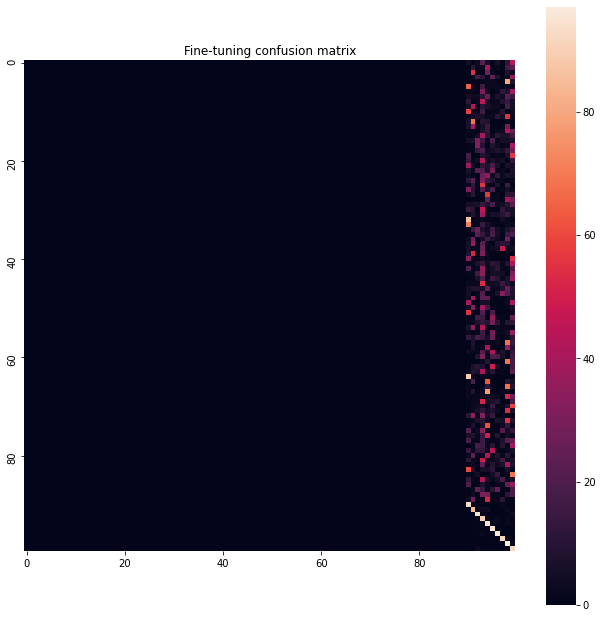

In [ ]:
def compute_confusion_matrix(y_t, y_p, plot=False):
      
    acc_matrix = s_cm(y_t, y_p)

    if plot:
        plt.figure(figsize=(11,11))
        df_cm = pd.DataFrame(acc_matrix)
        sn.heatmap(df_cm, square=True, xticklabels=20, yticklabels=20)
        plt.title("Fine-tuning confusion matrix")
        plt.show()

    return acc_matrix

cm = compute_confusion_matrix(y_true, y_pred, plot=True)